In [58]:
import pandas as pd
from dotenv import load_dotenv
import os
from google import genai
from sklearn.model_selection import train_test_split
import json
import pandas as pd
import openai
import os
from function_helper import create_summary_for_model_metrics
import matplotlib.pyplot as plt
import time

In [59]:
# df_merged = pd.read_csv("../data/merged_all_datasets.csv")
# df_merged = pd.read_csv("../data/merged_datasetes_balanced.csv")
df_merged = pd.read_csv("../data/merged_datasetes_balanced_huge.csv")

In [60]:
x_train, x_test, y_train, y_test = train_test_split(
    df_merged["title"], 
    df_merged["clickbait"],
    test_size=0.2, 
    random_state=42
)

x_test, x_val, y_test, y_val = train_test_split(
    x_test, 
    y_test,
    test_size=0.5,  # 50% of the original x_test size for validation
    random_state=42,
    stratify=y_test
)

In [61]:
x_test.shape

(4000,)

## LLMs testing

In [62]:
load_dotenv()

geminmi_api_key = os.getenv("GEMINI_API_KEY")
openai_api_key = os.getenv("OPENAI_API_KEY")

client_gemini = genai.Client()
client_openai = openai.OpenAI(api_key=openai_api_key)

MODEL_ID_GEMINI = "models/gemini-3-flash-preview"
MODEL_ID_OPENAI = "gpt-4o-mini"

GEMINI_BATCH_INPUT_FILE = "../data/gemini_batch_input.jsonl"
OPENAI_BATCH_INPUT_FILE = "../data/openai_batch_input.jsonl"

In [63]:
SYSTEM_INSTRUCTION="""
You are a strict classifier.
Task: determine whether a news article title is clickbait.
Definition: clickbait is a title that is intentionally sensational, misleading, or emotionally manipulative in order to attract clicks, often by exaggerating, omitting key facts, or using curiosity gaps.
Labels: {
"non-clickbait" : "0"
"clickbait" : "1" 
}

Rules:
- Base your decision only on the title.
- Do not explain your reasoning.
- Output only a single digit: 0 or 1.
"""

In [ ]:
SYSTEM_INSTRUCTION="""
You are a strict classifier.
Task: determine whether a news article title is clickbait.
Definition: clickbait is a title that is intentionally sensational, misleading, or emotionally manipulative in order to attract clicks, often by exaggerating, omitting key facts, or using curiosity gaps.
Labels: {
"non-clickbait" : "0"
"clickbait" : "1" 
}

Rules:
- Base your decision only on the title.
- Do not explain your reasoning.
- Output only a single digit: 0 or 1.
"""

In [29]:
def build_prompt(text: str) -> str:
    return f"Classify the title as clickbait or non-clickbait.\n\nTitle: {text}"

In [179]:
def map_prediction(results_map):
    final_predictions = pd.Series(results_map, name='value')
    successful_predictions = final_predictions.dropna()
    fault_predictions = final_predictions[final_predictions.isna()]
    return successful_predictions, fault_predictions


## Gemini

In [ ]:
with open(GEMINI_BATCH_INPUT_FILE, "w") as f:
    # Iterate over x_test. We use the pandas Index as custom_id to map results back later.
    for sample_id, title in x_test.items():
        request = {
            "custom_id": str(sample_id),  # CRITICAL: Keeps track of which result belongs to which title
            "method": "generateContent",
            "request": {
                "model": MODEL_ID_GEMINI,
                "system_instruction": {"parts": [{"text": SYSTEM_INSTRUCTION}]},
                "contents": [{"role": "user", "parts": [{"text": build_prompt(title)}]}],
                "generation_config": {
                    "temperature": 0.0,
                    "response_mime_type": "text/plain" # or "application/json" if you want strict JSON
                }
            }
        }
        f.write(json.dumps(request) + "\n")

In [ ]:
gemini_batch_file = client_gemini.files.upload(
    file=GEMINI_BATCH_INPUT_FILE, 
    config={'mime_type': 'application/json'}
)

In [33]:
print("Submitting batch job...")
job = client_gemini.batches.create(
    model="models/gemini-3-flash-preview",
    src=gemini_batch_file.name,
    config={"display_name": "clickbait_classification_job"}
)
gemini_job_name = job.name
print(gemini_job_name)


Submitting batch job...
batches/k3z88i9kebpt5wukklzod4pwcmwtryr8030h


In [140]:
def process_file_content(file_content: bytes) -> dict:
    text = file_content.decode('utf-8') # Assuming you already did this
    lines = text.splitlines()
    results = {}

    for line in lines:
        data = json.loads(line)
        custom_id = int(data['custom_id'])
        try:
            prediction_text = data['response']['candidates'][0]['content']['parts'][0]['text']
            results[custom_id] = int(prediction_text.strip())
            
        except (KeyError, IndexError, TypeError, ValueError):
            print(f"Failed to parse ID {custom_id}")
            results[custom_id] = None # or a default value like 0

    return results

In [186]:
batch_job = client_gemini.batches.get(name="batches/k3z88i9kebpt5wukklzod4pwcmwtryr8030h")
if batch_job.state.name == 'JOB_STATE_SUCCEEDED':

    # If batch job was created with a file
    if batch_job.dest and batch_job.dest.file_name:
        # Results are in a file
        result_file_name = batch_job.dest.file_name
        print(f"Results are in file: {result_file_name}")

  
        # print("Downloading result file content...")
        file_content = client_gemini.files.download(file=result_file_name)
        results_map_gemini = process_file_content(file_content)

    # If batch job was created with inline request
    # (for embeddings, use batch_job.dest.inlined_embed_content_responses)
    elif batch_job.dest and batch_job.dest.inlined_responses:
        # Results are inline
        print("Results are inline:")
        for i, inline_response in enumerate(batch_job.dest.inlined_responses):
            print(f"Response {i+1}:")
            if inline_response.response:
                # Accessing response, structure may vary.
                try:
                    print(inline_response.response.text)
                except AttributeError:
                    print(inline_response.response) # Fallback
            elif inline_response.error:
                print(f"Error: {inline_response.error}")
    else:
        print("No results found (neither file nor inline).")
else:
    print(f"Job did not succeed. Final state: {batch_job.state.name}")
    if batch_job.error:
        print(f"Error: {batch_job.error}")


Results are in file: files/batch-k3z88i9kebpt5wukklzod4pwcmwtryr8030h
Failed to parse ID 13174
Failed to parse ID 38701
Failed to parse ID 38285
Failed to parse ID 14360
Failed to parse ID 16079
Failed to parse ID 11635
Failed to parse ID 34089
Failed to parse ID 30745
Failed to parse ID 29869
Failed to parse ID 39158
Failed to parse ID 14295


0.834 & 0.866 & 0.789 & 0.826 & None \
{'Accuracy': np.float64(0.8342943093507145), 'Precision': np.float64(0.8662983425414365), 'Recall': np.float64(0.7891293407146452), 'F1 Score': np.float64(0.8259151962075324), 'ROC-AUC': None}

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      2002
           1       0.87      0.79      0.83      1987

    accuracy                           0.83      3989
   macro avg       0.84      0.83      0.83      3989
weighted avg       0.84      0.83      0.83      3989



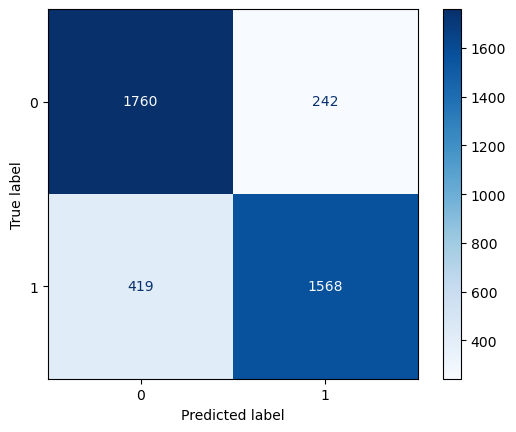

In [188]:
successful_predictions, fault_predictions = map_prediction(results_map_gemini)
create_summary_for_model_metrics(y_test.loc[successful_predictions.index], successful_predictions)

## OpenAI

### Zero shot evaluation with OpenAI GPT-4o-mini

In [65]:
with open(OPENAI_BATCH_INPUT_FILE, "w") as f:
    for sample_id, title in x_test.items():
        request = {
            "custom_id": str(sample_id),  # Maps back to your dataframe index
            "method": "POST",
            "url": "/v1/chat/completions",
            "body": {
                "model": MODEL_ID_OPENAI, # Cheap & fast (comparable to Gemini Flash)
                "messages": [
                    {"role": "system", "content": SYSTEM_INSTRUCTION},
                    {"role": "user", "content": build_prompt(title)}
                ],
                "max_tokens": 5,
                "temperature": 0
            }
        }
        f.write(json.dumps(request) + "\n")

print(f"Created {OPENAI_BATCH_INPUT_FILE}")

Created ../data/openai_batch_input.jsonl


In [67]:
# 1. Upload the file
print("Uploading file...")
batch_input_file = client_openai.files.create(
  file=open(OPENAI_BATCH_INPUT_FILE, "rb"),
  purpose="batch"
)

# 2. Create the Batch Job
print("Creating batch job...")
batch_job = client_openai.batches.create(
  input_file_id=batch_input_file.id,
  endpoint="/v1/chat/completions",
  completion_window="24h", # Currently the only option
  metadata={
    "description": "clickbait_classification_4k"
  }
)

print(f"Job created! ID: {batch_job.id}")
print(f"Status: {batch_job.status}")

Uploading file...
Creating batch job...
Job created! ID: batch_697f659d80948190921834e21cb79f66
Status: validating


In [72]:
job = client_openai.batches.retrieve(batch_job.id)
print(f"Status: {job.status}")

Status: completed


In [73]:
if job.output_file_id:
    file_response = client_openai.files.content(job.output_file_id)
    content = file_response.text

    results_map_openai = {}
    
    for line in content.splitlines():
        data = json.loads(line)
        custom_id = int(data['custom_id'])
        
        # OpenAI response structure
        # Note: Check for 'response' and 'body'
        try:
            choice = data['response']['body']['choices'][0]
            prediction = choice['message']['content'].strip()
            results_map_openai[custom_id] = int(prediction)
        except Exception as e:
            # Handle empty responses or content filters
            results_map_openai[custom_id] = 0 

    print(f"Retrieved {len(results_map_openai)} predictions.")


Retrieved 4000 predictions.


0.723 & 0.847 & 0.541 & 0.66 & None \
{'Accuracy': np.float64(0.72275), 'Precision': np.float64(0.8474842767295597), 'Recall': np.float64(0.5408931259407928), 'F1 Score': np.float64(0.6603369065849924), 'ROC-AUC': None}

              precision    recall  f1-score   support

           0       0.66      0.90      0.77      2007
           1       0.85      0.54      0.66      1993

    accuracy                           0.72      4000
   macro avg       0.76      0.72      0.71      4000
weighted avg       0.76      0.72      0.71      4000



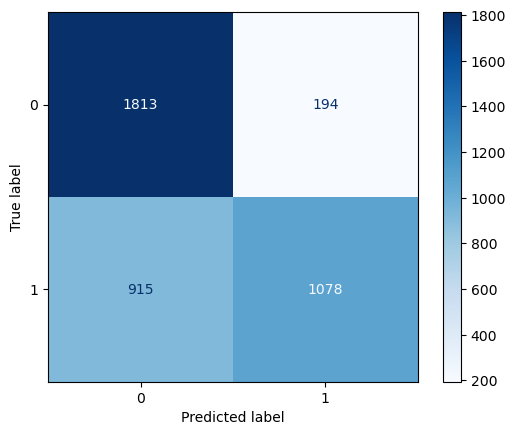

In [189]:
successful_predictions, fault_predictions = map_prediction(results_map_openai)
create_summary_for_model_metrics(y_test.loc[successful_predictions.index], successful_predictions)